In [1]:
import sys
sys.path.append("..")

In [2]:
import os
import numpy as np
import time
import load
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision import datasets, transforms,models
from torchvision.utils import save_image, make_grid
from fast_adv.attacks import DDN,CarliniWagnerL2
from fast_adv.utils import requires_grad_, l2_norm
import matplotlib.pyplot as plt
print(os.getcwd())

D:\Passive None-Line-of-Sight Recognition\Attacks


In [3]:
train_batch_size = 1
test_batch_size = 16
learning_rate = 0.01
num_epoches = 20
transform = transforms.ToTensor()

In [5]:
#下载MNIST数据集
train_dataset = load.MNIST(root='../data/',train=True,transform=transform,download=True)
test_dataset = load.MNIST(root='../data/',train=False,transform=transform ,download=True)
#将下载的MNIST数据导入到dataloader中
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=train_batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=test_batch_size,shuffle=False)

In [6]:
#下载MNIST数据集
#train_dataset = load.MNIST(root='./data/',train=True,transform=transform,download=False)
#test_dataset = load.MNIST(root='./data/',train=False,transform=transform ,download=False)
def random_split(dataset,ratio=0.8):
    train = []
    test = []
    for i in range(10):
        np.random.seed(42)
        data = torch.utils.data.Subset(dataset, (train_dataset.train_labels == i).nonzero().t()[0].tolist())
        train_size = 5
        test_size = len(data) - train_size
        train_db, val_db = torch.utils.data.random_split(data, [train_size, test_size])
        train.append(train_db)
        test.append(val_db)
    train_data= torch.utils.data.ConcatDataset(train)
    test_data=torch.utils.data.ConcatDataset(test)
    return train_data,test_data
torch.manual_seed(42)
train_data,test_data=random_split(train_dataset)

In [7]:
len(train_data)

50

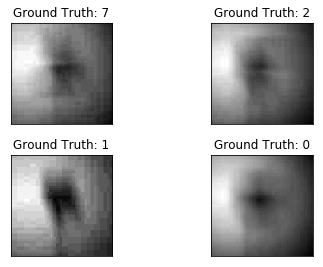

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
#print(next(examples)[1][0])
#print(example_data[0][0].shape)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0],cmap='gray')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [10]:
torch.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_path = r'logs/sy_Resnet.pkl'

In [11]:
print('Loading model')
model=models.resnet18(pretrained=True)
stride,kernel_size,padding,bias=model.conv1.stride,model.conv1.kernel_size,model.conv1.padding,model.conv1.bias
model.conv1=nn.Conv2d(1,64,kernel_size,stride,padding,bias=bias)
model.avgpool=nn.AvgPool2d(4,stride=1)
print(model.avgpool)
model.fc = nn.Linear(512,10)
#torch.save(model.state_dict(),model_path)
model.load_state_dict(torch.load(model_path))
model.eval().to(device)
requires_grad_(model, False)

Loading model
AvgPool2d(kernel_size=4, stride=1, padding=0)


In [13]:
dataset=train_data
delta=0.2
attacker = DDN(steps=25, device=device)
num_img_trn = len(dataset)
order = np.arange(num_img_trn)
v=torch.zeros(dataset[0][0].shape)
fooling_rate = 0.0
iter=0
while fooling_rate < 1-delta:
    for k in order:
        np.random.shuffle(order)
        r2 = int(model(dataset[k][0].unsqueeze(dim=0).cuda()).max(1)[1])
        torch.cuda.empty_cache()
        r1 = int(model((v+dataset[k][0]).unsqueeze(dim=0).cuda()).max(1)[1])
        #print(r1)
        torch.cuda.empty_cache()
        #print(r2,r1)
        if r1 == r2:
            print(">> k =", np.where(k==order)[0][0], ', pass #', iter)
            ddn_atk = attacker.attack(model, ((v+dataset[k][0]).data.clamp_(0, 1)).unsqueeze(dim=0).cuda(),
                                      dataset[k][1].unsqueeze(dim=0).cuda(),
                                      targeted=False)
            pred_ddn = model(ddn_atk).argmax(dim=1).cpu()
            acc= (pred_ddn != dataset[k][1].unsqueeze(dim=0).cpu()).float().mean().item()
            v=ddn_atk.squeeze(dim=0).cpu() - dataset[k][0]
            l2=(l2_norm(v)).mean().item()
            l2_xiangdui=(l2_norm(v)/torch.stack([(i.max()-i.min())*np.sqrt(dataset[k][0].shape[2]) for i in dataset[k][0]])).mean().item()
    iter+=1
    with torch.no_grad():
        # Compute fooling_rate
        est_labels_orig = torch.tensor(np.zeros(0, dtype=np.int64))
        est_labels_pert = torch.tensor(np.zeros(0, dtype=np.int64))
        def data_pert(x):
            return x+v
        transform1= transforms.Compose([transforms.ToTensor(),transforms.Lambda(data_pert)])
        test_data_pert= load.MNIST(root='../data/',train=False,transform=transform1,download=True)
        test_loader_pert = torch.utils.data.DataLoader(dataset=test_data_pert, batch_size=test_batch_size,shuffle=False)
        test_loader_orig=test_loader
        for batch_idx, (inputs, _) in enumerate(test_loader_orig):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            est_labels_orig = torch.cat((est_labels_orig, predicted.cpu()))
        torch.cuda.empty_cache()

        for batch_idx, (inputs, _) in enumerate(test_loader_pert):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            est_labels_pert = torch.cat((est_labels_pert, predicted.cpu()))
        torch.cuda.empty_cache()
        fooling_rate = float(torch.sum(est_labels_orig != est_labels_pert))/float(len(test_data_pert))
        print("FOOLING RATE: ", fooling_rate)

>> k = 25 , pass # 0
>> k = 24 , pass # 0
>> k = 11 , pass # 0
>> k = 46 , pass # 0
>> k = 39 , pass # 0
>> k = 31 , pass # 0
>> k = 22 , pass # 0
>> k = 18 , pass # 0
FOOLING RATE:  0.8967


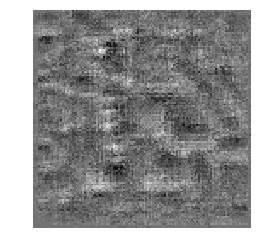

In [14]:
plt.imshow(v[0],cmap='gray')
plt.axis('off');

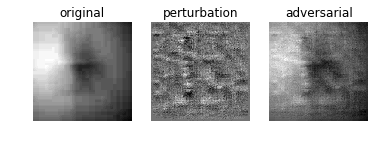

In [15]:
i=0
plt.subplot(1,3,1)
plt.imshow((test_dataset[i][0])[0],cmap='gray')
plt.title('original')
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(v[0],cmap='gray')
plt.title('perturbation')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(v[0]+test_dataset[i][0][0],cmap='gray')
plt.title('adversarial')
plt.axis('off');

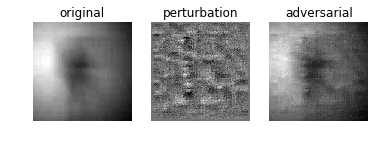

In [16]:
i=1
plt.subplot(1,3,1)
plt.imshow((test_dataset[i][0])[0],cmap='gray')
plt.title('original')
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(v[0],cmap='gray')
plt.title('perturbation')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(v[0]+test_dataset[i][0][0],cmap='gray')
plt.title('adversarial')
plt.axis('off');

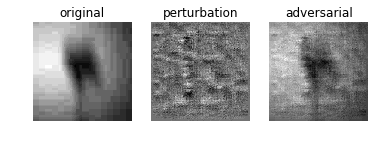

In [17]:
i=2
plt.subplot(1,3,1)
plt.imshow((test_dataset[i][0])[0],cmap='gray')
plt.title('original')
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(v[0],cmap='gray')
plt.title('perturbation')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(v[0]+test_dataset[i][0][0],cmap='gray')
plt.title('adversarial')
plt.axis('off');

In [67]:
unloader = transforms.ToPILImage()
image = unloader(v)
image.save('C:/Users/Qxslab/Desktop/1.png')

In [74]:
test_dataset[i][1]

tensor(7)

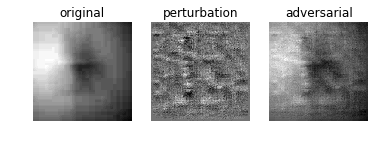

In [68]:
i=0
plt.subplot(1,3,1)
plt.imshow((test_dataset[i][0])[0],cmap='gray')
plt.title('original')
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(v[0],cmap='gray')
plt.title('perturbation')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(v[0]+test_dataset[i][0][0],cmap='gray')
plt.title('adversarial')
plt.axis('off');

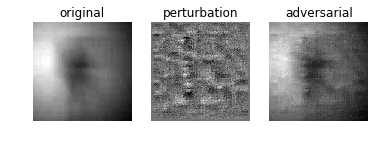

In [69]:
i=1
plt.subplot(1,3,1)
plt.imshow((test_dataset[i][0])[0],cmap='gray')
plt.title('original')
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(v[0],cmap='gray')
plt.title('perturbation')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(v[0]+test_dataset[i][0][0],cmap='gray')
plt.title('adversarial')
plt.axis('off');

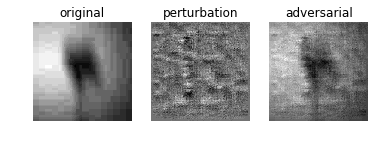

In [70]:
i=2
plt.subplot(1,3,1)
plt.imshow((test_dataset[i][0])[0],cmap='gray')
plt.title('original')
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(v[0],cmap='gray')
plt.title('perturbation')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(v[0]+test_dataset[i][0][0],cmap='gray')
plt.title('adversarial')
plt.axis('off');

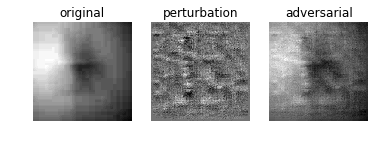

In [71]:
i=0
plt.subplot(1,3,1)
plt.imshow((test_dataset[i][0])[0],cmap='gray')
plt.title('original')
plt.axis('off');
plt.subplot(1,3,2)
plt.imshow(v[0],cmap='gray')
plt.title('perturbation')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(v[0]+test_dataset[i][0][0],cmap='gray')
plt.title('adversarial')
plt.axis('off');

tensor(6)


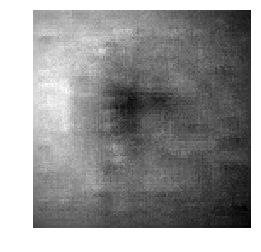

In [97]:
i=11
print(test_dataset[i][1])
plt.imshow(v[0],cmap='gray')
plt.axis('off');
plt.savefig('C:/Users/Qxslab/Desktop/tx/rd.png')
plt.imshow(test_dataset[i][0][0],cmap='gray')
plt.axis('off');
plt.savefig('C:/Users/Qxslab/Desktop/tx/sy.png')
plt.imshow(v[0]+test_dataset[i][0][0],cmap='gray')
plt.axis('off');
plt.savefig('C:/Users/Qxslab/Desktop/tx/mn.png')

In [89]:
test_dataset[i][1]

tensor(7)

In [39]:
unloader = transforms.ToPILImage()
image = unloader(v)
image.save('C:/Users/Qxslab/Desktop/2.png')

In [40]:
transforms.ToPILImage()

ToPILImage()

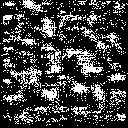

In [83]:
transforms.ToPILImage()(v).convert('L')

In [80]:
v.max()*255

tensor(11.0000)

In [81]:
v.min()*255

tensor(-9.0000)